# Prevendo os alunos treineiros do Enem 2016

## Setup

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import string as str
import matplotlib.pyplot as plt
import scipy.stats as sct
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [125]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Predict
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, #clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

In [126]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [127]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

## Análise Exploratória de Dados

In [128]:
test.shape

(4570, 43)

In [129]:
train.shape

(13730, 167)

Nota-se que a base de dados de treino possui colunas a mais do que a base de dados de testes. Assim, o primeiro passo será transformar a base de treino numa base compatível com a base de testes. 

In [130]:
colunas_test = test.columns
train_new = train[colunas_test]
train_new

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,80.0,520.0,D,D,C,A,A,C,H,A
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,80.0,580.0,A,A,B,A,A,A,NaN,A
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,...,NaN,NaN,D,D,C,A,A,A,NaN,A
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,...,NaN,NaN,H,E,E,C,B,C,F,D
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,...,NaN,NaN,E,D,C,A,A,B,F,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13725,aadf671ef8c1c6efa42e69432093ab83c17a52ac,35,SP,20,M,1,1,1,3,1,...,40.0,440.0,E,E,G,B,B,B,C,A
13726,461f7ef2753d9d5fa0b054930d6b0e0eec318e81,26,PE,33,F,3,2,1,10,1,...,80.0,560.0,A,A,C,A,B,B,I,A
13727,5354503700ecf2388f68990435390b6e1ad454ee,43,RS,15,F,1,1,3,0,1,...,120.0,600.0,C,G,B,A,B,A,NaN,A
13728,c7a9e94a42bd76b7978f13c013a61702e36cc42c,33,RJ,36,M,3,1,4,0,1,...,100.0,460.0,B,D,G,B,B,C,E,A


Além disso, vamos incluir a `IN_TREINEIRO` nos dados de treino, pois essa é a variável independente que queremos treinar no nosso modelo

In [131]:
train_new = pd.concat([train_new, train['IN_TREINEIRO']], axis = 1)
train_new

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,IN_TREINEIRO
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,520.0,D,D,C,A,A,C,H,A,0
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,580.0,A,A,B,A,A,A,NaN,A,0
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,...,NaN,D,D,C,A,A,A,NaN,A,0
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,...,NaN,H,E,E,C,B,C,F,D,0
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,...,NaN,E,D,C,A,A,B,F,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13725,aadf671ef8c1c6efa42e69432093ab83c17a52ac,35,SP,20,M,1,1,1,3,1,...,440.0,E,E,G,B,B,B,C,A,0
13726,461f7ef2753d9d5fa0b054930d6b0e0eec318e81,26,PE,33,F,3,2,1,10,1,...,560.0,A,A,C,A,B,B,I,A,0
13727,5354503700ecf2388f68990435390b6e1ad454ee,43,RS,15,F,1,1,3,0,1,...,600.0,C,G,B,A,B,A,NaN,A,1
13728,c7a9e94a42bd76b7978f13c013a61702e36cc42c,33,RJ,36,M,3,1,4,0,1,...,460.0,B,D,G,B,B,C,E,A,0


### 1 - Tratando os dados da base de treino

In [132]:
analise_train = pd.DataFrame({'tipo': train_new.dtypes,
                    'missing' : train_new.isna().sum(),
                    'size' : train_new.shape[0],
                    'unicos': train_new.nunique()})
analise_train['percentual_missing'] = round(analise_train['missing'] / analise_train['size'],3)
analise_train

,tipo,missing,size,unicos,percentual_missing
NU_INSCRICAO,object,0,13730,13730,0.000
CO_UF_RESIDENCIA,int64,0,13730,27,0.000
SG_UF_RESIDENCIA,object,0,13730,27,0.000
NU_IDADE,int64,0,13730,55,0.000
TP_SEXO,object,0,13730,2,0.000
TP_COR_RACA,int64,0,13730,6,0.000
TP_NACIONALIDADE,int64,0,13730,5,0.000
TP_ST_CONCLUSAO,int64,0,13730,4,0.000
TP_ANO_CONCLUIU,int64,0,13730,11,0.000
TP_ESCOLA,int64,0,13730,4,0.000


In [133]:
analise_train[analise_train['missing']!=0]

,tipo,missing,size,unicos,percentual_missing
TP_ENSINO,float64,9448,13730,3,0.688
TP_DEPENDENCIA_ADM_ESC,float64,9448,13730,4,0.688
NU_NOTA_CN,float64,3389,13730,2692,0.247
NU_NOTA_CH,float64,3389,13730,2978,0.247
NU_NOTA_LC,float64,3597,13730,2774,0.262
TP_STATUS_REDACAO,float64,3597,13730,9,0.262
NU_NOTA_COMP1,float64,3597,13730,15,0.262
NU_NOTA_COMP2,float64,3597,13730,13,0.262
NU_NOTA_COMP3,float64,3597,13730,12,0.262
NU_NOTA_COMP4,float64,3597,13730,14,0.262


As colunas `TP_ENSINO`, `TP_DEPENDENCIA_ADM_ESC` e `Q027` possuem mais de 50% dos dados nulos, assim essas colunas não apresentam muita informação para auxiliar o modelo e, serão excluídas da análise.

Observando a análise abaixo, temos que a coluna `NU_NOTA_REDACAO` é a soma dos valores das colunas `NU_NOTA_COMP1`, `NU_NOTA_COMP2`, `NU_NOTA_COMP3`, `NU_NOTA_COMP4` e `NU_NOTA_COMP5`, assim temos que toda a informação está na coluna NU_NOTA_REDACAO, portanto ficaremos somente com essa coluna na base de dados.

In [134]:
train_complete = train_new.copy()
columns_to_drop = ['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'Q027']
train_complete.drop(columns_to_drop, axis=1, inplace=True)

Na análise do desafio anterior, também vimos que os IDs com valores null na redação provavelmente não realizaram a prova (esses Ids também não possui informação para a nota de matemática e as provas foram realizadas no mesmo dia). Assim vamos remover esses Ids da base.

In [135]:
train_complete.dropna(subset=['NU_NOTA_REDACAO'], inplace = True)
analise_train_2 = pd.DataFrame({'tipo': train_complete.dtypes,
                    'missing' : train_complete.isna().sum(),
                    'size' : train_complete.shape[0],
                    'unicos': train_complete.nunique()})
analise_train_2['percentual_missing'] = round(analise_train_2['missing'] / analise_train_2['size'],3)
analise_train_2[analise_train_2['missing']!=0]

,tipo,missing,size,unicos,percentual_missing
NU_NOTA_CN,float64,36,10133,2680,0.004
NU_NOTA_CH,float64,36,10133,2963,0.004


Os valores null que ainda estão presentes serão preenchidos com a média da coluna

In [136]:
NU_NOTA_CN_mean = train_complete['NU_NOTA_CN'].mean()
train_complete['NU_NOTA_CN'].fillna(NU_NOTA_CN_mean, inplace=True)

NU_NOTA_CH_mean = train_complete['NU_NOTA_CH'].mean()
train_complete['NU_NOTA_CH'].fillna(NU_NOTA_CH_mean, inplace=True)

In [137]:
analise_train_2 = pd.DataFrame({'tipo': train_complete.dtypes,
                    'missing' : train_complete.isna().sum(),
                    'size' : train_complete.shape[0],
                    'unicos': train_complete.nunique()})
analise_train_2['percentual_missing'] = round(analise_train_2['missing'] / analise_train_2['size'],3)
analise_train_2[analise_train_2['missing']!=0]

,tipo,missing,size,unicos,percentual_missing


### 2 - Tratando os dados da base de teste

Aplicando a mesmo processo para tratamento dos valores null da base de treinos para a base de testes

In [138]:
test_complete = test.copy()
test_complete.drop(columns_to_drop, axis=1, inplace=True)

test_complete.dropna(subset=['NU_NOTA_REDACAO'], inplace = True)

NU_NOTA_CN_mean_test = test_complete['NU_NOTA_CN'].mean()
test_complete['NU_NOTA_CN'].fillna(NU_NOTA_CN_mean_test, inplace=True)

NU_NOTA_CH_mean_test = test_complete['NU_NOTA_CH'].mean()
test_complete['NU_NOTA_CH'].fillna(NU_NOTA_CH_mean_test, inplace=True)
test_complete

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q047
3,5c356d810fa57671402502cd0933e5601a2ebf1e,41,PR,17,F,1,1,2,0,2,...,1,1.0,480.0,E,E,E,C,B,B,A
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,53,DF,19,F,1,1,1,1,1,...,1,1.0,720.0,E,E,E,B,B,B,A
5,3f28749fb79fb059caf5aed79625a5addfd7a91a,35,SP,18,F,1,1,2,0,2,...,0,1.0,480.0,C,C,C,B,B,A,A
7,cc7cab347fe5455aae983f3701ca40f84dc01949,23,CE,18,M,3,1,2,0,2,...,1,1.0,560.0,D,E,C,B,B,A,A
8,95e9338f1da02f7bfa0e3194130afdccc0fb5457,51,MT,16,M,1,1,3,0,1,...,0,1.0,500.0,G,F,Q,B,B,A,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565,361b7fcd8867119550fe2af5aa729ffad89a7cf5,31,MG,17,F,2,1,2,0,3,...,1,1.0,620.0,B,E,D,B,B,A,D
4566,d8a0e4c9e29494cc9bba2422bd79333931475ee1,35,SP,20,F,1,1,1,2,1,...,1,1.0,320.0,A,B,B,A,A,C,B
4567,3f1c3388244df8d6521e983a809292d9f3bca643,11,RO,22,F,3,1,1,5,1,...,1,1.0,500.0,D,E,E,B,A,B,A
4568,1778e9c4cef591beb6b986d191d15ed05de816b0,35,SP,19,M,1,1,2,0,2,...,0,1.0,520.0,H,D,B,B,B,A,A


Salvando os IDs que foram removidos da base de testes, que serão utilizados para montar a base dos resultados

In [139]:
alunos_sem_nota_mat_test = list(test[test['NU_NOTA_REDACAO'].isna() == True]['NU_INSCRICAO'])
ID_test = pd.DataFrame({'NU_INSCRICAO': list(test_complete['NU_INSCRICAO'])+list(alunos_sem_nota_mat_test)})
ID_test.shape

(4570, 1)

### Continuação do tratamento de dados


Analisando os tipos das colunas dos dados

In [140]:
train_complete.dtypes

NU_INSCRICAO          object
CO_UF_RESIDENCIA       int64
SG_UF_RESIDENCIA      object
NU_IDADE               int64
TP_SEXO               object
TP_COR_RACA            int64
TP_NACIONALIDADE       int64
TP_ST_CONCLUSAO        int64
TP_ANO_CONCLUIU        int64
TP_ESCOLA              int64
IN_BAIXA_VISAO         int64
IN_CEGUEIRA            int64
IN_SURDEZ              int64
IN_DISLEXIA            int64
IN_DISCALCULIA         int64
IN_SABATISTA           int64
IN_GESTANTE            int64
IN_IDOSO               int64
TP_PRESENCA_CN         int64
TP_PRESENCA_CH         int64
TP_PRESENCA_LC         int64
TP_PRESENCA_MT         int64
NU_NOTA_CN           float64
NU_NOTA_CH           float64
NU_NOTA_LC           float64
TP_LINGUA              int64
TP_STATUS_REDACAO    float64
NU_NOTA_REDACAO      float64
Q001                  object
Q002                  object
Q006                  object
Q024                  object
Q025                  object
Q026                  object
Q047          

Nesse primeiro momento, as colunas com type `object`serão removidas da análise

In [141]:
cat_col = train_complete.columns[train_complete.dtypes == 'object']
train_int = train_complete.drop(cat_col, axis=1, inplace=False)
test_int = test_complete.drop(cat_col, axis=1, inplace=False)

### Análise estatísticos dos dados

Analisando o comportamento dos dados da coluna `IN_TREINEIRO` presente no dados de teste

In [142]:
train_int['IN_TREINEIRO'].describe()

count    10133.000000
mean         0.148525
std          0.355637
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: IN_TREINEIRO, dtype: float64

Como a coluna `IN_TREINEIRO` só pode assumir 1 e 0, podemos ver que existe um desbalanceamento dos dados dessa coluna, pois a média não é 0,5. Com a média podemos assumir que 14.85% dos dados são 1 (o aluno é treineiro) enquanto o resto 85.15% são 0 (alunos que não foram treineiros)

In [143]:
train_int['IN_TREINEIRO'].value_counts()

0    8628
1    1505
Name: IN_TREINEIRO, dtype: int64

#### Balanceando os dados

In [144]:
smote = SMOTE(sampling_strategy="minority")
treineiro = train_int['IN_TREINEIRO']
train_atual, in_treineiro_balanceado = smote.fit_resample(train_int.iloc[:, :-1], treineiro)
train_atual = pd.DataFrame(train_atual)
in_treineiro_balanceado = pd.DataFrame(in_treineiro_balanceado)
train_balanced = pd.concat([train_atual, in_treineiro_balanceado], axis = 1, ignore_index = False)

In [145]:
train_balanced['IN_TREINEIRO'].value_counts()

1    8628
0    8628
Name: IN_TREINEIRO, dtype: int64

Agora vamos analisar a correlação dos dados em relação a coluna `IN_TREINEIRO`

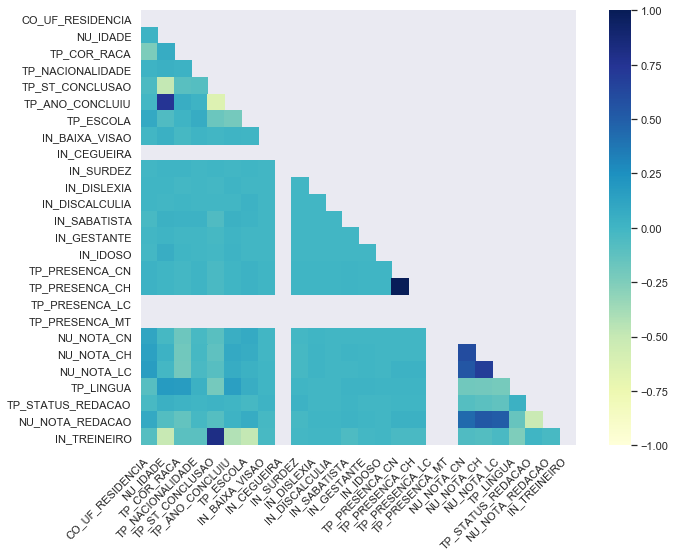

In [146]:
matrix = np.triu(train_balanced.corr())
corr = train_balanced.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='YlGnBu',
    square=True,
    mask = matrix
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Podemos verificar que existe uma correlação com a coluna `TP_ST_CONCLUSAO`. Isso ocorre pois essa coluna traz a situação atual do aluno com relação ao Ensino Médio. Assim, treineiros são aqueles que ainda estão cursando o Ensino médio e não o terminarão antes de 2016. 
Mesmo assim, vamos treinar o modelo com todas as varíaveis para ver quais resultados obtemos.

## Aplicando os classificadores

In [147]:
X_data = train_balanced.drop('IN_TREINEIRO',axis=1)
y_data = train_balanced['IN_TREINEIRO']
x_train, x_test, y_train, y_test = train_test_split(X_data,y_data,test_size = 0.2,random_state=1)

### Logistic Regression

Verificando o score do método:

In [148]:
logistic = LogisticRegression()
logistic.fit(x_train, y_train)
print('Logistic Regression Score : ',logistic.score(x_test,y_test))#Ratio of correct predictions

Logistic Regression Score :  0.9866743916570104


C:\Users\romul\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### K-Nearest Neighbors

In [149]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(x_train,y_train)
print('K-Nearest Neighbors Score : ',knn.score(x_test,y_test))

K-Nearest Neighbors Score :  0.8276361529548089


### Support Vector Machine

In [150]:
svm = SVC(random_state = 1)
svm.fit(x_train,y_train)
print('Super Vector Machine Score : ',svm.score(x_test,y_test))

Super Vector Machine Score :  0.6263035921205099


### Naive Bayes

In [151]:
nb = GaussianNB()
nb.fit(x_train,y_train)
print('Naive Bayes Score : ',nb.score(x_test,y_test))

Naive Bayes Score :  0.981460023174971


### Decision Tree

In [152]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
print('Decision Tree Score : ',dt.score(x_test,y_test))

Decision Tree Score :  0.9971031286210892


### Random Forest

In [153]:
rf = RandomForestClassifier(n_estimators = 22,random_state = 40)
rf.fit(x_train,y_train)
print('Random Forest Score : ',rf.score(x_test,y_test))

Random Forest Score :  0.9979721900347625


Realizando a previsão com o melhor algoritmo, para esse exemplo foi o **Random Forest**

In [213]:
rf.fit(X,y)
prediction = rf.predict(test_int)
prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Estruturando a resposta para o teste do resultado

In [217]:
prediction_df = pd.DataFrame({'IN_TREINEIRO':prediction})
answer = pd.concat([ID_test, prediction_df], axis = 1, ignore_index = False)
answer['IN_TREINEIRO'].fillna(0, inplace=True)
#answer.to_csv(r'address', index=False)